In [1]:
# %tensorflow_version 2.x
import os, math, json, shutil
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd

from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D

from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!conda list | grep tensorflow

tensorflow                2.1.0           mkl_py37h80a91df_0  
tensorflow-base           2.1.0           mkl_py37h6d63fb7_0  
tensorflow-estimator      2.1.0              pyhd54b08b_0  


# 0. Data Pre-analysis

In [3]:
images = glob('data/IDC_regular_ps50_idx5/**/*png', recursive=True)
class0 = [x for x in images if 'class0' in x]
class1 = [x for x in images if 'class1' in x]

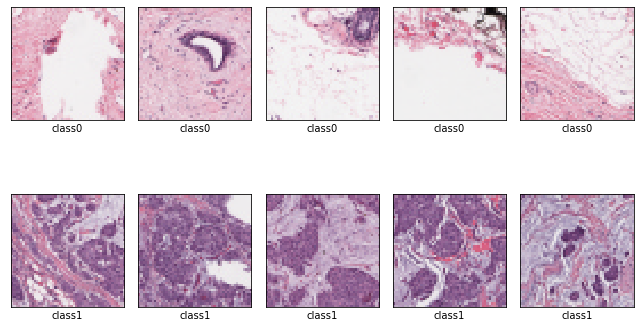

In [4]:
# Load some images
def plot_sample_image(list1, list2):
    fig, axes = plt.subplots(2, 5, figsize=(9, 6))
    axes = axes.flatten()
    classList = ['class0' for _ in list1] + ['class1' for _ in list2]
    combList = list1 + list2
    for img, datalabel, ax in zip(combList, classList, axes):
        image = Image.open(img)
        ax.imshow(image)
        ax.set_xlabel(datalabel)
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()

plot_sample_image(class0[:5], class1[:5])

In [5]:
print ('Class0: ', len(class0), 'images')
print ('Class1: ', len(class1), 'images')
print ('Ratio:', round(len(class1)/len(class0), 2))

Class0:  198738 images
Class1:  78786 images
Ratio: 0.4


Ideally, we should have a balance between the different classes for training. Let's random sample and downscale the train and test sets first.

In [6]:
N_IMAGE = 1500
def subsample(list_path):
    from random import shuffle
    output = []
    shuffle(list_path)
    for img in list_path:
        if np.random.randn() > 0.999999999:
            output.append(img)
        if len(output) == N_IMAGE:
            return output
        

class0_subsample = subsample(class0)
class1_subsample = subsample(class1)

In [7]:
print ('Class0_ss: ', len(class0_subsample), 'images')
print ('Class1_ss: ', len(class1_subsample), 'images')
print ('Total:', len(class0_subsample)+len(class1_subsample))
print ('Ratio:', round(len(class1_subsample)/len(class0_subsample), 2))

Class0_ss:  1500 images
Class1_ss:  1500 images
Total: 3000
Ratio: 1.0


Splitting into train and test sets (80:20)

In [9]:
for folder in ['ss_train', 'ss_test']:
    for subfolder in ['0', '1']:
        if not os.path.exists(f'data/{folder}/{subfolder}'):
            os.makedirs(f'data/{folder}/{subfolder}')
# else:
#     try:
if len(os.listdir('data/ss_train/0/')) > 0:
    shutil.rmtree('data/ss_train')
#     except:
#         pass
#     try:
if len(os.listdir('data/ss_test/0/')) > 0:
    shutil.rmtree('data/ss_test')
#     except:
#         pass
    
def split_train_test(list1, list2):
    count = 0
    for img1, img2 in zip(list1, list2):
#         print (count)
        if count != 2*N_IMAGE*0.8:
            count += 2
            shutil.copy(img1, 'data/ss_train/0')
            shutil.copy(img2, 'data/ss_train/1')
            
        else:
            shutil.copy(img1, 'data/ss_test/0')
            shutil.copy(img2, 'data/ss_test/1')
split_train_test(class0_subsample, class1_subsample)        
#     train_set = []
#     test_set = []
#     for img1, img2 in zip(list1, list2):
#         image1 = np.asarray(load_img(img1, target_size=(50, 50)))
# #         print (image1.shape)
#         image2 = np.asarray(load_img(img2, target_size=(50, 50)))
#         np.insert(image1, -1, 0.)
#         np.insert(image2, -1, 1.)
#         if len(train_set) < 3200:
            
# #             print (len(train_set))
#             train_set.append(image1)
#             train_set.append(image2)
#         else:
# #             print (len(test_set))
#             test_set.append(image1)
#             train_set.append(image2)
    
#     train_set = np.array(train_set)
# #     train_set = np.reshape(train_set, (3600, 4), 'C')
#     test_set = np.array(test_set)
# #     test_set = np.reshape(test_set, (400, 4), 'C')
#     return train_set, test_set

# train_set, test_set = split_train_test(class0_subsample, class1_subsample)

# print (test_set.shape, train_set.shape)

In [10]:
BATCH_SIZE = 32
INPUT_SIZE = (50, 50)
print ("Getting Training Data")
trainGenerator = ImageDataGenerator(
                rescale=1./255, 
                rotation_range=30,
#                 zoom_range=0.15,
                width_shift_range=0.15, 
                height_shift_range=0.15, 
                horizontal_flip=True,
                vertical_flip=True,
                )

print ("Subsampling Training Set")
train_set = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'ss_train'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical',
                    classes=['0', '1'],
                    subset='training')

print ("Test Data")
test_set = ImageDataGenerator(
                rescale=1./255
                ).flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory=os.path.join('data', 'ss_test'),
                    target_size=INPUT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical',
                    classes=['0', '1'])

num_train_data = train_set.n

Getting Training Data
Subsampling Training Set
Found 2400 images belonging to 2 classes.
Test Data
Found 600 images belonging to 2 classes.


# 1. Training

In [11]:
epochs = 24
model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=0.1),
    
#     Conv2D(128, 3, padding='same', activation='relu'),
#     MaxPooling2D(3, strides=2),
#     Dropout(0.2, seed=0.1),
    
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=0.1),
    
    Conv2D(512, 3, padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=0.1),
    
    Conv2D(768, 3, padding='same', activation='relu'),
    MaxPooling2D(3, strides=2),
    Dropout(0.2, seed=0.1),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.1, seed=111),
    Dense(2, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(epsilon=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 256)       147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 11, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 512)       1

In [12]:
early_stop = EarlyStopping(patience=10, verbose=1)

LR_reduce = ReduceLROnPlateau(monitor='val_accuracy', 
                            patience=7, 
                            verbose=1, 
                            factor=1/2, 
                            min_lr=1e-5)
callbacks = [early_stop, LR_reduce]

In [13]:
history = model.fit(train_set, 
                    steps_per_epoch=50,#math.ceil(num_train_data/BATCH_SIZE), 
                    epochs=epochs,
                    validation_data=test_set,
                    callbacks=callbacks,
        )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 19 steps
Epoch 1/24
50/50 [==============================] - 27s 532ms/step - loss: 0.7045 - accuracy: 0.5113 - AUC: 0.5208 - Precision: 0.5113 - Recall: 0.5113 - val_loss: 0.6928 - val_accuracy: 0.5000 - val_AUC: 0.5822 - val_Precision: 0.5000 - val_Recall: 0.5000
Epoch 2/24
50/50 [==============================] - 23s 465ms/step - loss: 0.6134 - accuracy: 0.6831 - AUC: 0.7329 - Precision: 0.6831 - Recall: 0.6831 - val_loss: 0.7534 - val_accuracy: 0.5000 - val_AUC: 0.6279 - val_Precision: 0.5000 - val_Recall: 0.5000
Epoch 3/24
50/50 [==============================] - 23s 452ms/step - loss: 0.6272 - accuracy: 0.6744 - AUC: 0.7182 - Precision: 0.6744 - Recall: 0.6744 - val_loss: 0.6803 - val_accuracy: 0.5100 - val_AUC: 0.6311 - val_Precision: 0.5100 - val_Recall: 0.5100
Epoch 4/24
50/50 [==============================] - 23s 464ms/step - loss: 0.5745 - accuracy: 0.7219 - AUC: 0.7739 - Precision: 0.7219 - 

True

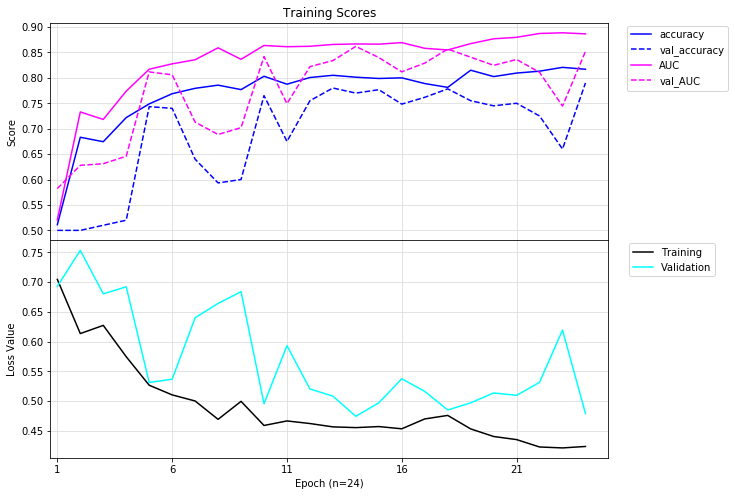

In [14]:
def plotHistory(history, plot=False):
    """
    Plots the evalation metrics of the trained model. Included metrics are
    accuracy, AUC, and loss in both training and validation data. Optionally,
    precision and recall metrics can also be plotted.
    Input: training history object
    Output: Two subplots showing the evaluation scores w.r.t. to the epoch.

    Note: any missing key (evaluation metric) from the history.history 
    dictionary will raise an exception and the plots would not be generated.
    The first missing key will be printed as the exception.
    """
    try:
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        minVal, maxVal = 1, 0
        finalEpoch = len(history.history['accuracy'])
        for result in history.history:
            if 'loss' not in result:
                for val in history.history[result]:
                    if val < minVal: minVal = val
                    if val > maxVal: maxVal = val
        plt.title(f'Training Scores')#\nModel:{now}')
        colors = ['blue', 'magenta', 'red', 'green']
        for z, met in enumerate(['accuracy', 'AUC']):#, 'Precision', 'Recall']):
            plt.plot(range(1, finalEpoch+1), history.history[met],
                        color=colors[z], label=met)
            plt.plot(range(1, finalEpoch+1), history.history[f"val_{met}"], '--',
                        color=colors[z], label=f"val_{met}")
#         plt.plot(range(1, finalEpoch+1), history.history['accuracy'], 
#                  color='blue', label='Accuracy')
#         plt.plot(range(1, finalEpoch+1), history.history['val_accuracy'], '--', 
#                  color='blue', label='valAccuracy')
#         plt.plot(range(1, finalEpoch+1), history.history['AUC'], 
#                  color='magenta', label='AUC')
#         plt.plot(range(1, finalEpoch+1), history.history['val_AUC'], '--', 
#                  color='magenta', label='valAUC')
        plt.xticks(range(1, finalEpoch+1, 5))
        plt.xlim((0.7, finalEpoch+1))
        plt.ylabel('Score')
        plt.grid(color='#DDDDDD')
        plt.tick_params(axis='x', labelcolor='#FFFFFF')
        plt.legend(bbox_to_anchor=(1.025, 1.01))
        plt.subplots_adjust(hspace=0.001)

        plt.subplot(2, 1, 2)
        plt.ylabel('Loss Value')
        plt.xlabel(f'Epoch (n={finalEpoch})')
        plt.xticks(range(1, finalEpoch+1, 5))
        plt.xlim((0.7, finalEpoch+1))
        plt.plot(range(1, finalEpoch+1), history.history['loss'], 
                 color='black', label='Training')
        plt.plot(range(1, finalEpoch+1), history.history['val_loss'], 
                 color='cyan', label='Validation')
        plt.grid(color='#DDDDDD')
        plt.legend(bbox_to_anchor=(1.2, 1.01))
        
        
        if plot:
            plt.tight_layout()
            plt.subplots_adjust(hspace=0)
#             plt.savefig(os.path.join(PROJECT_PATH, 
#                                      f'{now}.png'))
        return True
    except Exception as E:
        print ('Unable to produce figure, missing key:', E) 
        return False

plotHistory(history)

In [15]:
model.evaluate(test_set)

  ...
    to  
  ['...']
19/19 [==============================] - 2s 131ms/step - loss: 0.4789 - accuracy: 0.7900 - AUC: 0.8521 - Precision: 0.7900 - Recall: 0.7900


[0.4789480065044604, 0.79, 0.8520819, 0.79, 0.79]

In [16]:
def predict_cancer(image_path):
#     target_size = model.input_shape[1:3]
#     ori_size = load_img(image_path)
#     img_to_predict = load_img(image_path, target_size=target_size)
#     img_to_predict = np.asarray(img_to_predict)
    
# #     plt.imshow(ori_size)
#     img_to_predict = np.expand_dims(img_to_predict, axis=0)
    
    prediction = model.predict_classes(image_path)[0]#, 0]
    probability = model.predict_classes(image_path)[0]#, 0]
#     if prediction == 0:
#         prediction = 1
#         probability = 1 - probability
#     plt.axis('off')
#     plt.yticks([])
#     plt.xticks([])
#     plt.tight_layout()
#     plt.title(f"Prediction: {prediction}")
#     plt.show()
    return prediction, probability

In [17]:
from sklearn.metrics import confusion_matrix

In [18]:
confusion_matrix(test_set.labels,
                     [np.argmax(x) for x in model.predict_generator(test_set)])

Instructions for updating:
Please use Model.predict, which supports generators.


array([[155, 145],
       [145, 155]])